# Step 0

* Read the h5 file containing the scan data.
* Make sure the scan went as expected.
* Process the camera images.
    * Crop
    * Threshold
    * Downscale
* Create a new h5 file with separate scalar (0D), waveform (1D), and image (2D) data sets. The new file name is "prepoc-" + the original file name.
* Save useful information to pass to future notebooks; e.g., slit limits/correlations.

In [1]:
import sys
import os
from os.path import join
from datetime import datetime
import importlib
from pprint import pprint
import json
import numpy as np
import pandas as pd
import h5py
import skimage
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from ipywidgets import interactive
from ipywidgets import widgets
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from matplotlib import patches
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['grid'] = False

## Load data

In [3]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2021-12-03'
filenames = os.listdir(datadir)
filenames

['211203142341-scan-xxpy-image-ypdE-metadata.json',
 '211203142341-scan-xxpy-image-ypdE.csv',
 '211203142341-scan-xxpy-image-ypdE.h5',
 '211203142341-scan-xxpy-image-ypdE.html',
 '211203142341-scan-xxpy-image-ypdE.png',
 '211203142341-scan-xxpy-image-ypdE.txt',
 '211203143323-scan-xxpy-image-ypdE-metadata.json',
 '211203143323-scan-xxpy-image-ypdE.csv',
 '211203143323-scan-xxpy-image-ypdE.h5',
 '211203143323-scan-xxpy-image-ypdE.html',
 '211203143323-scan-xxpy-image-ypdE.png',
 '211203143323-scan-xxpy-image-ypdE.txt',
 '211203143850-scan-xxpy-image-ypdE-metadata.json',
 '211203143850-scan-xxpy-image-ypdE.csv',
 '211203143850-scan-xxpy-image-ypdE.h5',
 '211203143850-scan-xxpy-image-ypdE.html',
 '211203143850-scan-xxpy-image-ypdE.png',
 '211203143850-scan-xxpy-image-ypdE.txt',
 '211203144659-scan-xxpy-image-ypdE-metadata.json',
 '211203144659-scan-xxpy-image-ypdE.csv',
 '211203144659-scan-xxpy-image-ypdE.h5',
 '211203144659-scan-xxpy-image-ypdE.html',
 '211203144659-scan-xxpy-image-ypdE.

In [4]:
filename = 'merged2-211203151919-211203192701-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, filename + '.h5'), 'r')
print(list(file))

['scandata']


In [5]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    metadata = dict()
    for name in config['metadata'].dtype.names:
        metadata[name] = config['metadata'][name]
else:
    # Older measurement; metadata is in json file.
    metadata = json.load(open(join(datadir, filename + '-metadata.json'), 'r'))
    _metadata = dict()
    for _dict in metadata.values():
        for key, value in _dict.items():
            _metadata[key] = value
    metadata = _metadata
    pprint(metadata)

{'BTF_MEBT_Mag:PS_DCH01:I_Set': 6.0,
 'BTF_MEBT_Mag:PS_DCH02:I_Set': 2.0,
 'BTF_MEBT_Mag:PS_DCV01:I_Set': 2.0,
 'BTF_MEBT_Mag:PS_DCV02:I_Set': 0.0,
 'BTF_MEBT_Mag:PS_DH07:I_Set': 359.0,
 'BTF_MEBT_Mag:PS_QH01:I_Set': 157.94000244140625,
 'BTF_MEBT_Mag:PS_QH03:I_Set': 6.75,
 'BTF_MEBT_Mag:PS_QH05:I_Set': 0.0,
 'BTF_MEBT_Mag:PS_QH08:I_Set': 3.521,
 'BTF_MEBT_Mag:PS_QH11:I_Set': 7.539000034332275,
 'BTF_MEBT_Mag:PS_QH13:I_Set': 6.349999904632568,
 'BTF_MEBT_Mag:PS_QH33:I_Set': 5.989999771118164,
 'BTF_MEBT_Mag:PS_QV02:I_Set': 280.05999755859375,
 'BTF_MEBT_Mag:PS_QV04:I_Set': -3.8,
 'BTF_MEBT_Mag:PS_QV06:I_Set': -1.0,
 'BTF_MEBT_Mag:PS_QV07:I_Set': -3.05,
 'BTF_MEBT_Mag:PS_QV09:I_Set': -1.5499999523162842,
 'BTF_MEBT_Mag:PS_QV10:I_Set': -2.0999999046325684,
 'BTF_MEBT_Mag:PS_QV12:I_Set': -7.400000095367432,
 'BTF_MEBT_Mag:PS_QV34:I_Set': -7.599999904632568,
 'ITSF_Diag:Cam06:Brightness': 100.0,
 'ITSF_Diag:Cam06:Exp': 2000,
 'ITSF_Diag:Cam06:Gain': 0,
 'ITSF_Diag:Cam06:Magn': 3,
 'ITSF_Di

In [6]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

In [7]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)
print(f"nbytes = {data.nbytes:.3e}")

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('cam06_Image', (dtype(('<i4', (89268,))), 16))
   ('cam06_ProfileY', (dtype(('<f4', (258,))), 357088))
   ('cam06_ProfileX', (dtype(('<f4', (346,))), 358120))
   ('cam06_Saturation', (dtype('<f8'), 359504))
   ('cam06_Integral', (dtype('<f8'), 359512))
   ('bcm04', (dtype('<f8'), 359520))
   ('y_PositionSync', (dtype('<f8'), 359528))
   ('xp_PositionSync', (dtype('<f8'), 359536))
   ('x_PositionSync', (dtype('<f8'), 359544))
nbytes = 2.077e+10


In [8]:
acts = ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']

In [9]:
info = dict()  # to pass info between notebooks
info['acts'] = acts
info['datadir'] = datadir
info['filename'] = filename

In [10]:
print(f'data.nbytes = {data.nbytes:.2e}')

data.nbytes = 2.08e+10


## Scan overview 

Input the min/max slit coordinates, shearing matrix, and boundary (box, ellipsoid) here. These will be used in subsequent notebooks.

In [11]:
# Slit ranges, steps, and limits
ndim = 3
variables = {
    'y1': {
        'pvname': 'ITSF_Diag:Slit_HZ04',
        'center': 14.5,
        'distance': 22.0,
        'steps': 32,
        'min': -50.0,
        'max': +50.0,
    },   
    'x2': {
        'pvname': 'ITSF_Diag:Slit_VT06',
        'center': 13.50,
        'distance': 13.0,
        'steps': 32,
        'min': -50.0,
        'max': +50.0,
    },
    'x1': {
        'pvname': 'ITSF_Diag:Slit_VT04',
        'center': 13.0,
        'distance': 17.0,
        'steps': 32,
        'min': -50.0, 
        'max': +50.0,
    }
}

# An affine transformation M is applied to the regular grid defined above.
keys = list(variables)
M = np.identity(ndim)
M[keys.index('x2'), keys.index('x1')] = 0.65

# Save to info dict
info['variables'] = variables
info['M'] = M
info['ndim'] = ndim

# Save these for later.
center = np.array([variables[key]['center'] for key in keys])
distance = np.array([variables[key]['distance'] for key in keys])
nsteps = np.array([variables[key]['steps'] for key in keys])

### Data collection frequency

In [12]:
duration = data[-1, 'timestamp'] - data[0, 'timestamp']
iteration_duration = duration / data[-1, 'iteration']
points_per_iteration = len(data) / data[-1, 'iteration']
print(f'{len(data)} points recorded over {duration:.1f} seconds ({(duration / 3600.0):.1f} hours)')
print(f"Number of iterations: {data[-1, 'iteration']}")
print(f'Effective rep rate: {(len(data) / duration):.2f} Hz')
print(f'Time per iteration: {iteration_duration:.2f} seconds')
print(f'Points per iteration: {points_per_iteration:.2f}')

57766 points recorded over 17595.4 seconds (4.9 hours)
Number of iterations: 1089
Effective rep rate: 3.28 Hz
Time per iteration: 16.16 seconds
Points per iteration: 53.04


Look for long pauses during data collection.

reprate = 5.00 Hz
Pauses longer than 30 seconds:
array([4661.10853982])
Most pauses are 1.40 seconds


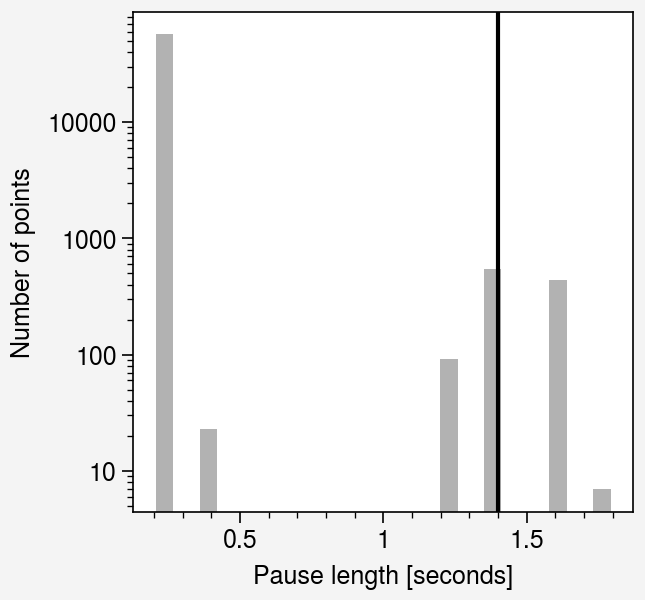

In [13]:
dt = np.diff(data['timestamp'][:])
rep_rate = 1.0 / np.median(dt)
print(f'reprate = {rep_rate:.2f} Hz')

print('Pauses longer than 30 seconds:')
long_pause = 30.0
pprint(dt[dt > long_pause])
dt[dt > long_pause] = 0.2

hist, bins = np.histogram(dt, bins=21)
idx_bins = np.digitize(dt, bins)
idx_pause, = np.where(idx_bins > 1)
median_pause = np.median(dt[idx_pause])
print(f'Most pauses are {median_pause:.2f} seconds')

fig, ax = pplt.subplots()
ax.bar(0.5 * (bins[1:] + bins[:-1]), hist, color='black', alpha=0.3)
ax.axvline(median_pause, color='black')
ax.format(xlabel='Pause length [seconds]', ylabel='Number of points', yscale='log')
plt.savefig('_output/pauses.png')

### BCM current

In [14]:
bcm = 'bcm04'
bcm_limit = 20.0  # [mA]
bcm_data = np.copy(data[bcm][:])

idx = np.arange(len(data))
valid_bcm, = np.where(np.abs(bcm_data) > bcm_limit)
mask_bcm, = np.where(np.abs(bcm_data) <= bcm_limit)

print(f'Average BCM current (before masking) = {np.mean(bcm_data):.3f} +- {np.std(bcm_data):.3f} [mA]')
for i in mask_bcm:
    print(f'Point {i} masked due to {bcm} current < {bcm_limit:.3f} [mA]')
print('Average BCM current (after masking) = {:.3f} +- {:.3f} [mA]'
      .format(np.mean(bcm_data[valid_bcm]), np.std(bcm_data[valid_bcm])))

Average BCM current (before masking) = -30.249 +- 0.285 [mA]
Point 12039 masked due to bcm04 current < 20.000 [mA]
Point 23125 masked due to bcm04 current < 20.000 [mA]
Point 28507 masked due to bcm04 current < 20.000 [mA]
Point 36677 masked due to bcm04 current < 20.000 [mA]
Point 37583 masked due to bcm04 current < 20.000 [mA]
Point 39390 masked due to bcm04 current < 20.000 [mA]
Point 42479 masked due to bcm04 current < 20.000 [mA]
Average BCM current (after masking) = -30.252 +- 0.046 [mA]


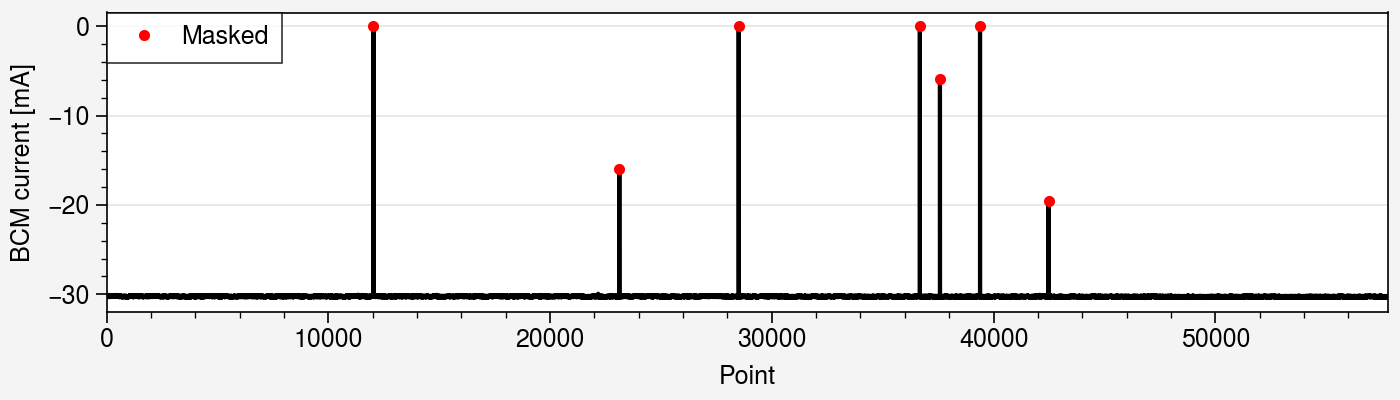

In [15]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(bcm_data, color='black')
ax.plot(mask_bcm, bcm_data[mask_bcm], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
plt.savefig('_output/bcm_mask.png')
plt.show()

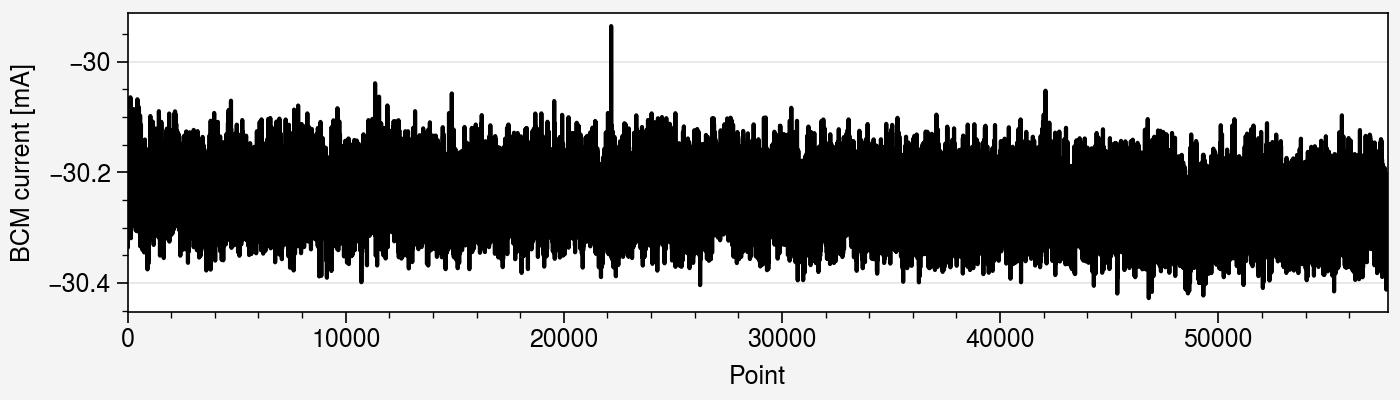

In [16]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(bcm_data[np.abs(bcm_data) > bcm_limit], color='black')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
plt.savefig('_output/bcm_unmasked_points.png')
plt.show()

### Camera integral/saturation

Get camera name and settings.

In [17]:
# Find camera name.
cam = None
for name in data.dtype.names:
    if 'cam' in name.lower():
        cam = name.split('_')[0]
        
## Find camera zoom. 
zoom = None
for key in metadata:
    if 'Magn' in key:
        zoom = 1.0 / float(metadata[key])
        print(f'Found zoom={zoom} in metadata. Please verify!')
        
## The above code doesn't always work; is 'Magn' not equivalent to zoom?
## If it gives the wrong zoom, type it manually here.
zoom = 0.33
        
# Load camera settings. 
cam_settings = ip.CameraSettings(cam)
cam_settings.set_zoom(zoom)
print(f'Image shape = {cam_settings.shape}. Please verify!')

## May need to set correct image shape manually.
cam_settings.shape = (258, 346)

# Save info.
info['cam'] = cam_settings.name
info['cam_zoom'] = cam_settings.zoom
info['cam_pix2mm_y'] = info['cam_pix2mm_x'] = cam_settings.pix2mm
info['cam_shape'] = cam_settings.shape

print(f"cam = '{cam}'")
print(f'zoom = {zoom}')
print(f'pix2mm = {cam_settings.pix2mm} (zoom = {zoom})')
print(f'image shape = {cam_settings.shape}')

Found zoom=0.3333333333333333 in metadata. Please verify!
Image shape = (512, 612). Please verify!
cam = 'cam06'
zoom = 0.33
pix2mm = 0.19969696969696968 (zoom = 0.33)
image shape = (258, 346)


View saturation during scan.

In [18]:
saturation = data.fields(cam + '_Saturation')[:]

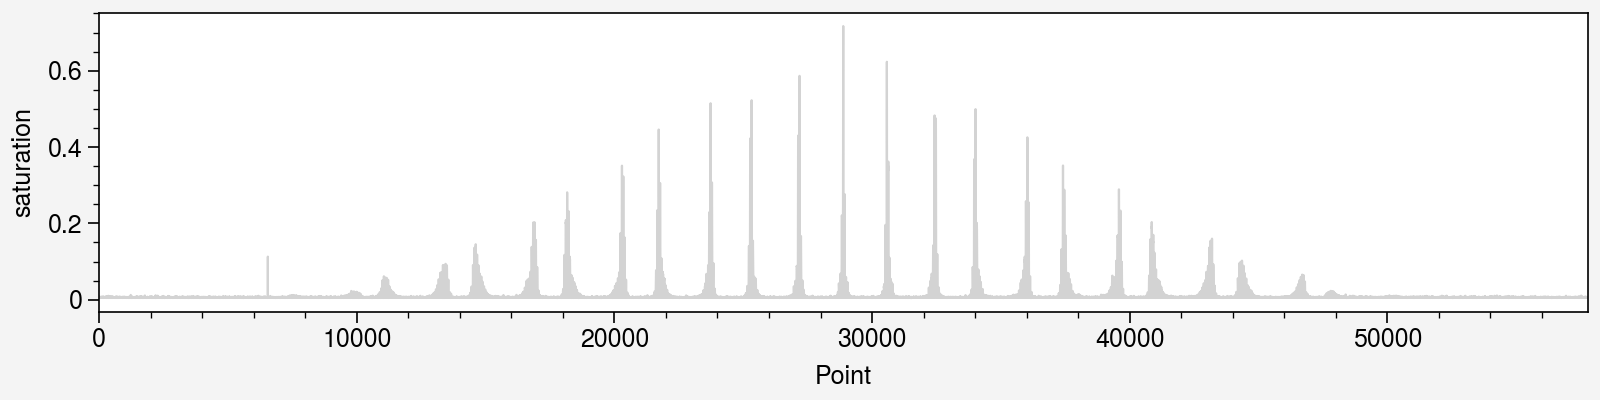

In [19]:
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.plot(saturation, color='lightgrey', lw=0.8)
ax.format(ylabel='saturation', xlabel='Point')
plt.savefig(f'_output/{cam}_Saturation.png')

Define `signal` as the camera integral normalized to the range [0, 1]. Subtract the minimum from the signal and normalize to the range [0, 1] (Usually there is a constant offset/floor of the camera integral). Tune `thresh` until no black dots are in regions that clearly have no signal.

In [20]:
signal = data.fields(cam + '_Integral')[:]

Fractional signal thresh = 0.00175
Fraction of points above thresh: 0.2074576740643285


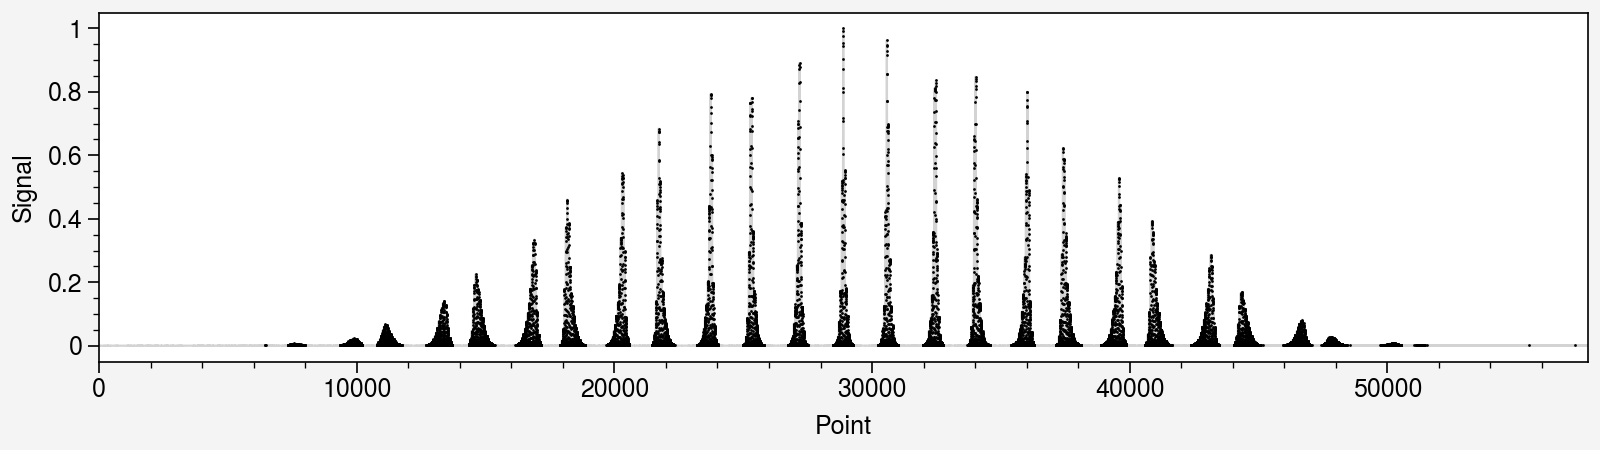

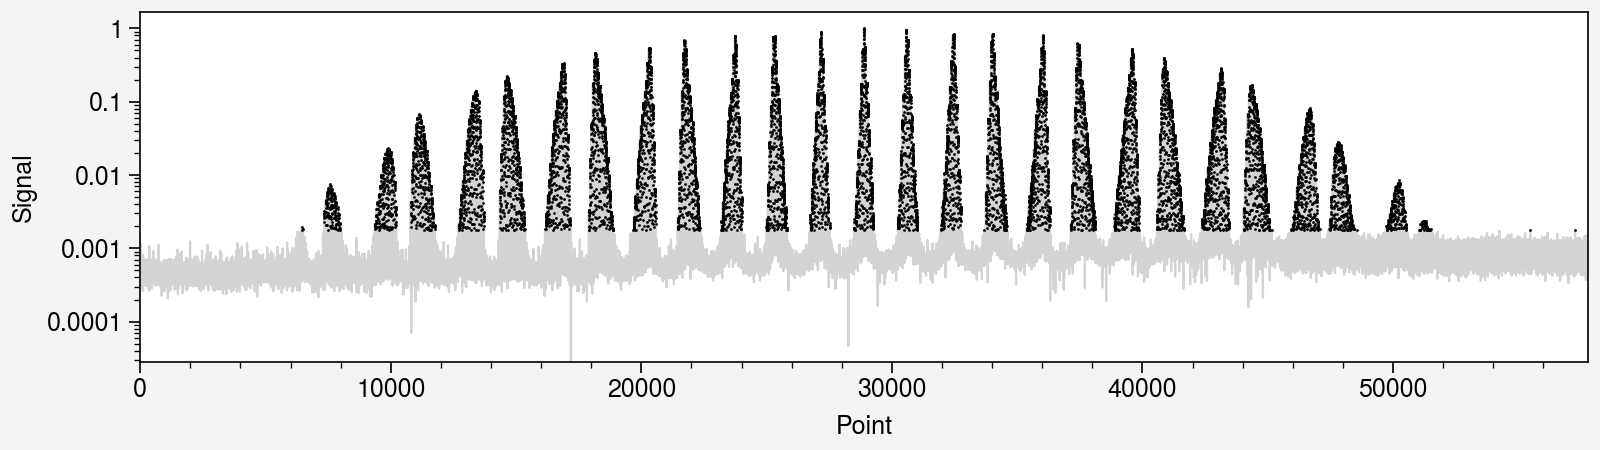

In [21]:
signal = signal - np.min(signal)
signal = signal / np.max(signal)
thresh = 0.00175  # fraction of max signal
valid, = np.where(signal >= thresh)
invalid, = np.where(signal < thresh)

info['signal_thresh'] = thresh
print(f'Fractional signal thresh = {thresh}')
print(f'Fraction of points above thresh: {len(valid) / len(signal)}')
for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.25))
    ax.plot(signal, color='lightgrey', lw=0.8)
    ax.plot(valid, signal[valid], lw=0, marker='.', ms=2, alpha=1, ec='None', color='black')
    ax.format(yscale=yscale, ylabel='Signal', xlabel='Point')
    plt.savefig(f'_output/signal_thresh_{yscale}.png')

### Actuator coordinates 

In [22]:
points = np.vstack([data[act] for act in acts]).T
points_n = utils.apply(np.linalg.inv(M), points - center)
points_nn = points_n / (0.5 * distance)

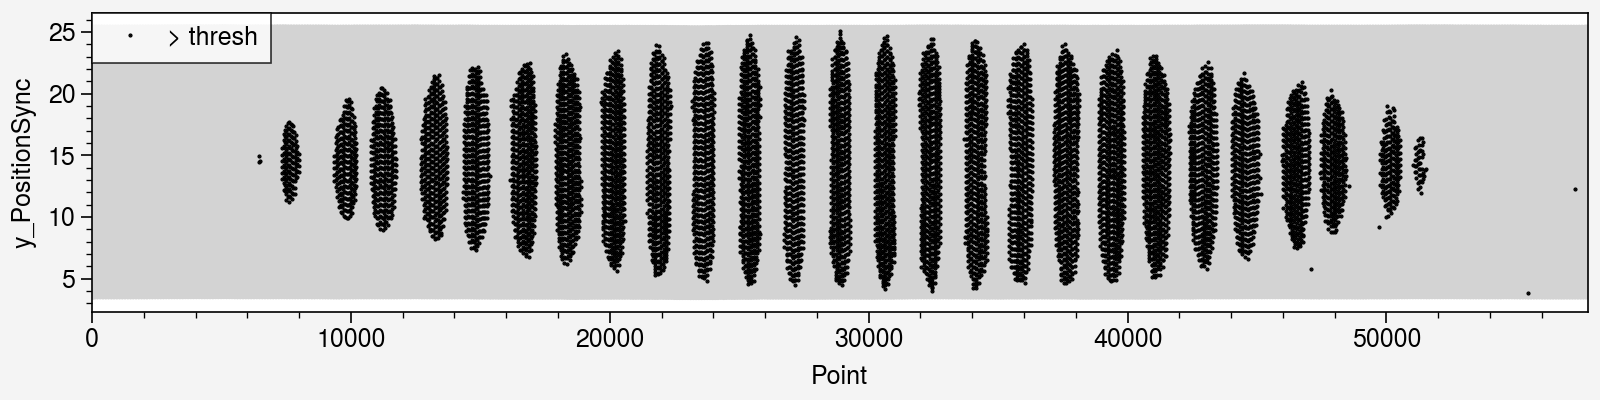

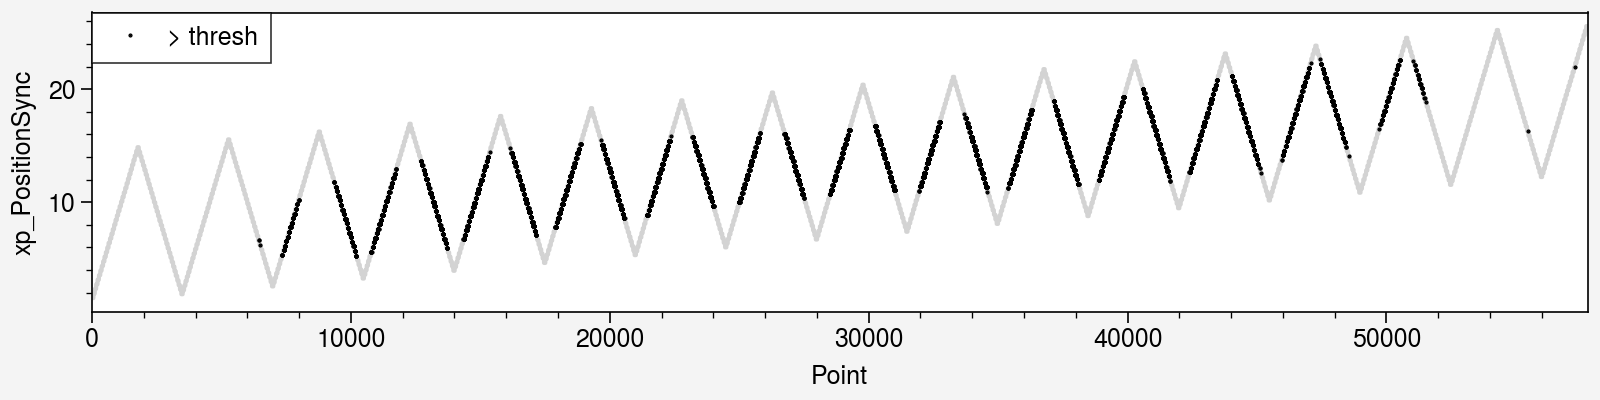

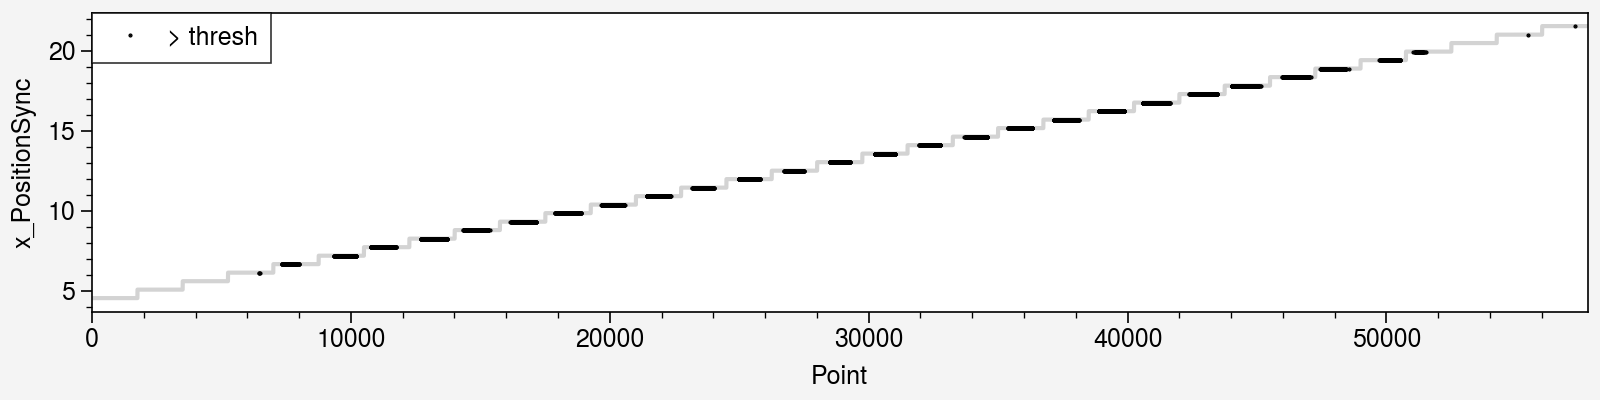

In [23]:
for i, act in enumerate(acts):
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(points[:, i], color='lightgray')
    ax.plot(valid, points[valid, i], color='black', marker='.', ms=1, lw=0, label='> thresh')
    ax.format(xlabel='Point', ylabel=act)
    ax.legend(loc='upper left')
    plt.savefig('_output/acts.png')
    plt.show()

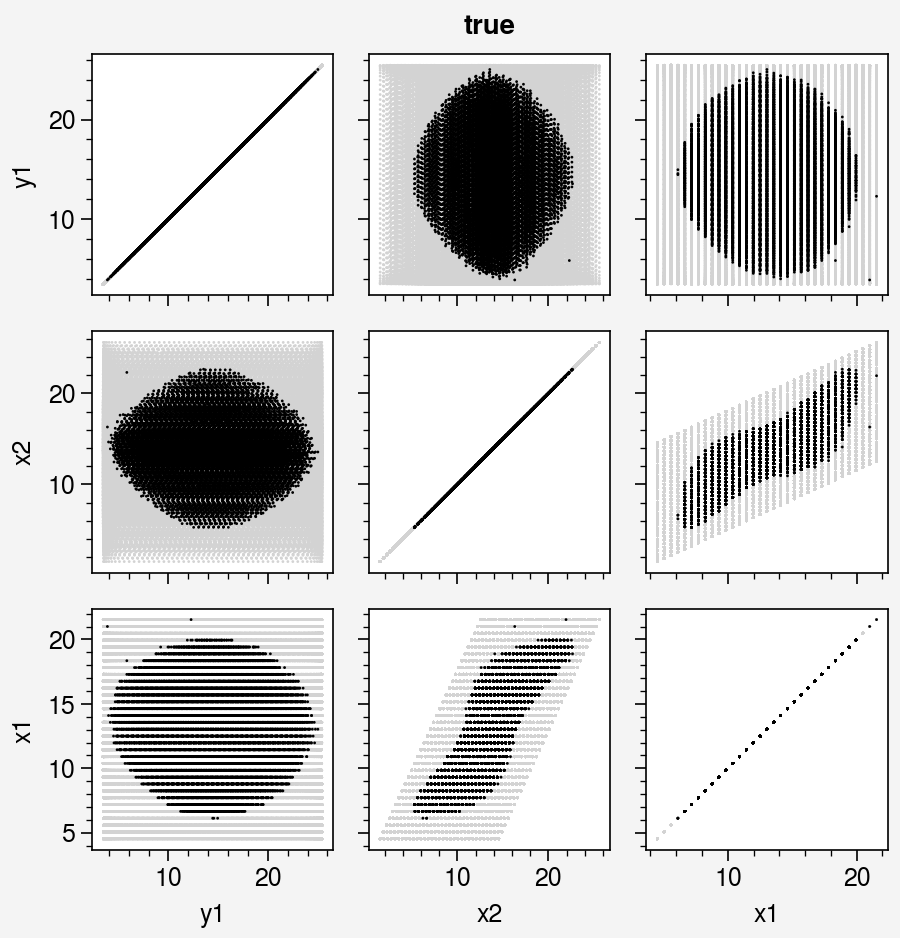

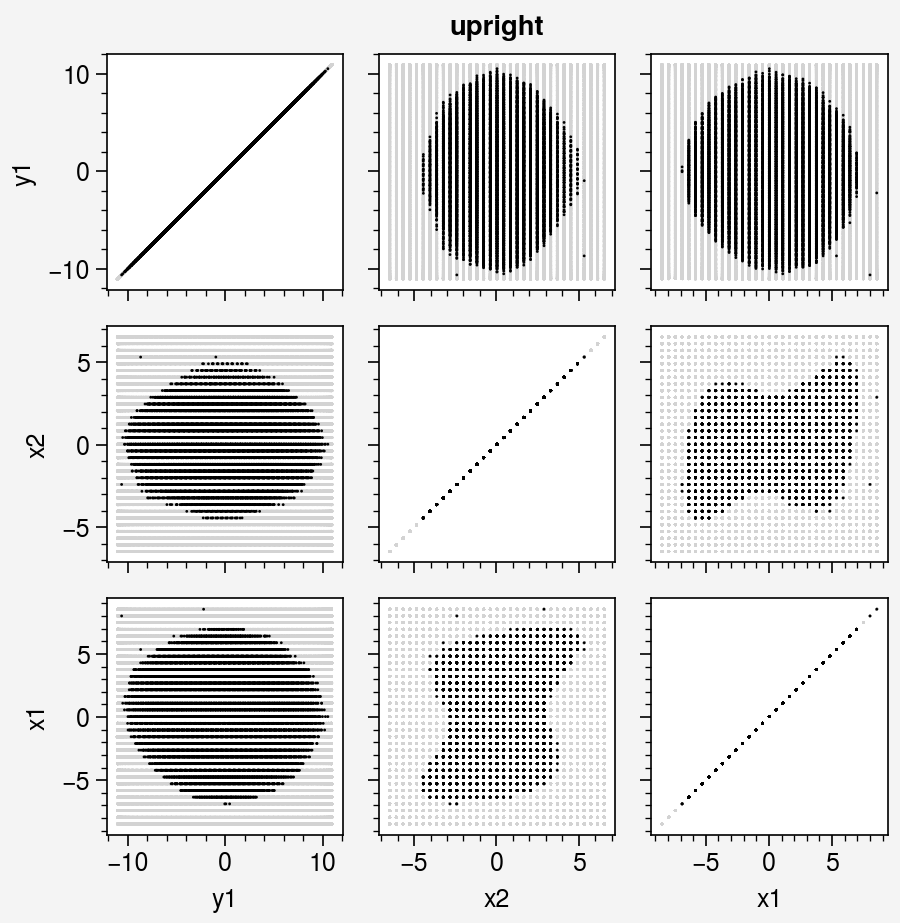

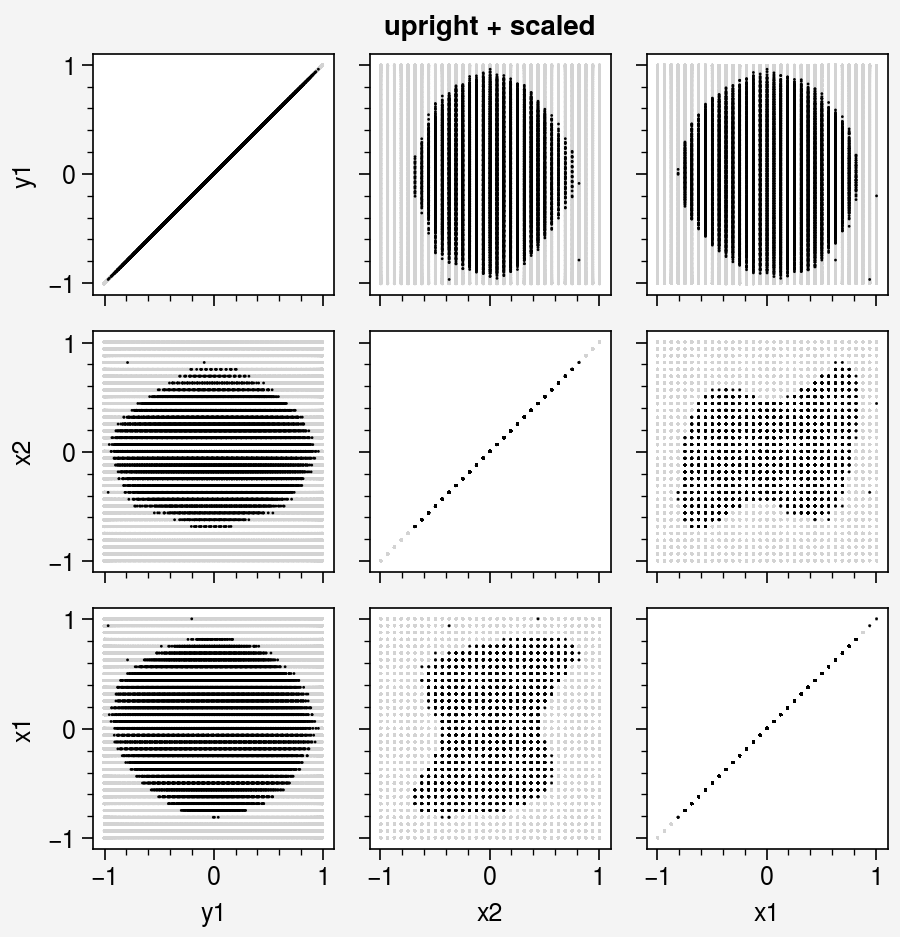

In [24]:
for _points, title in zip((points, points_n, points_nn), ('true', 'upright', 'upright + scaled')):
    fig, axes = pplt.subplots(ncols=3, nrows=3, figwidth=4.5, span=False)
    axes.format(suptitle=title)
    for i in range(3):
        for j in range(3):
            axes[i, j].scatter(_points[:, j], _points[:, i], c='lightgray', ec='None', s=1)
            axes[i, j].scatter(_points[valid, j], _points[valid, i], c='black', ec='None', s=1)
        axes[i, 0].format(ylabel=keys[i])
        axes[-1, i].format(xlabel=keys[i])
    plt.savefig(f'_output/points_{title}.png')

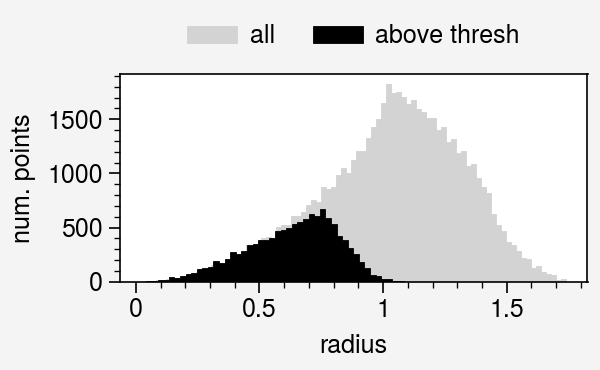

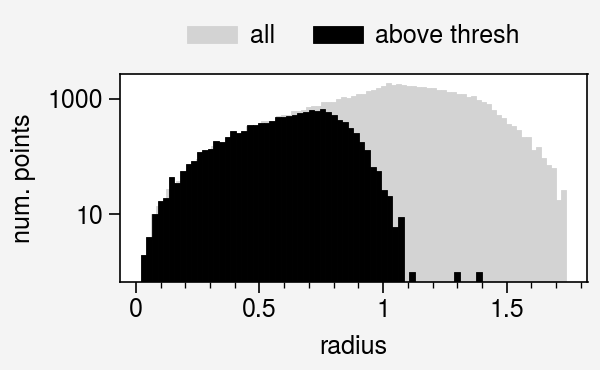

In [25]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))
with pplt.rc.context(legendfontsize='medium'):
    for yscale in [None, 'log']:
        fig, ax = pplt.subplots(figsize=(3, 1.85))
        ax.hist(radii, bins='auto', label='all', color='lightgrey')
        ax.hist(radii[valid], bins='auto', label='above thresh', color='black')
        ax.format(ylabel='num. points', xlabel='radius', yscale=yscale)
        ax.legend(ncols=2, loc='top', framealpha=0)
        plt.savefig(f'_output/radial_dist_{yscale}.png')

In [26]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points_nn[invalid, 0], 
            y=points_nn[invalid, 1], 
            z=points_nn[invalid, 2], 
            mode='markers', 
            marker=dict(color='lightgray', size=1, opacity=0.5),
        ),
        go.Scatter3d(
            x=points_nn[valid, 0], 
            y=points_nn[valid, 1], 
            z=points_nn[valid, 2], 
            mode='markers', 
            marker=dict(color='black', size=1, opacity=0.5),
        ),
    ],
)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.update_layout(width=500, height=500)
fig.write_html('_output/points_nn3d.html')
# fig.show()

In [27]:
del fig

## Image processing

Use the images with the largest/smallest integral for testing image processing.

In [28]:
def get_image(i):
    """Return the reshaped image."""
    return data[i, cam + '_Image'].reshape(cam_settings.shape)

def plot_compare_images(im1, im2, **plot_kws):
    """Plot images side by side, and a second row in log scale."""
    fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
    for col, im in enumerate([im1, im2]):
        for row, norm in enumerate([None, 'log']):
            mplt.plot_image(im.T / np.max(im), ax=axes[row, col], norm=norm, **plot_kws)
    return axes

In [29]:
imax = np.argmax(signal)
imin = np.argmin(signal)
im_max = get_image(imax)
im_min = get_image(imin)
print(f'Max {cam}_Integral at i = {imax}')
print(f'Min {cam}_Integral at i = {imin}')

Max cam06_Integral at i = 28881
Min cam06_Integral at i = 17189


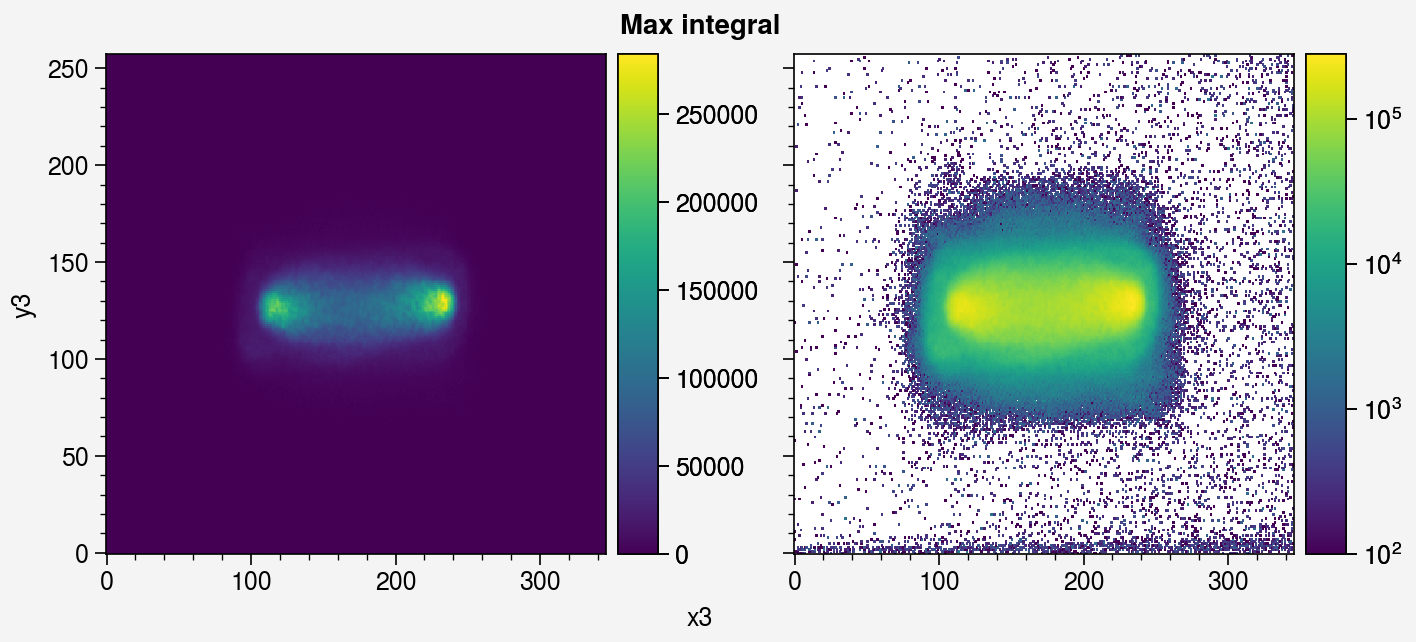

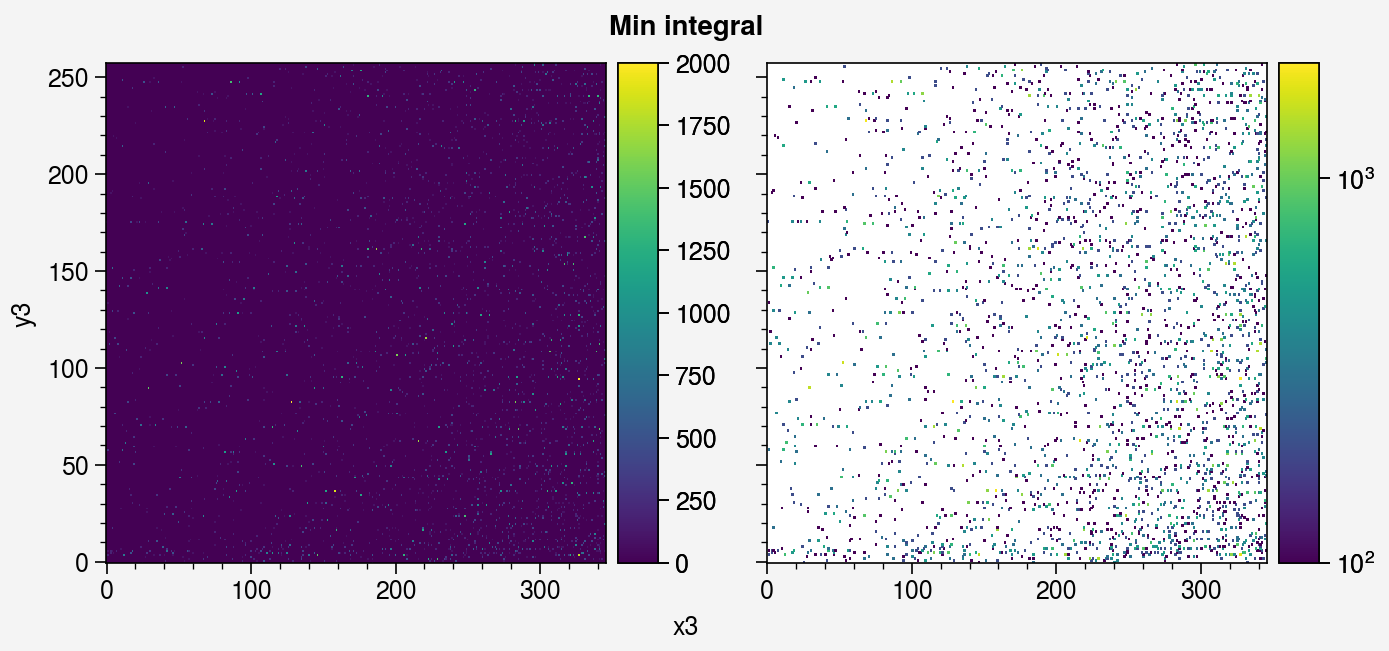

In [30]:
for im, title in zip((im_max, im_min), ('Max integral', 'Min integral')):
    fig, axes = pplt.subplots(ncols=2)
    kws = dict(colorbar=True)
    mplt.plot_image(im.T, ax=axes[0], **kws)
    mplt.plot_image(im.T, ax=axes[1], norm='log', **kws)
    axes.format(xlabel='x3', ylabel='y3', suptitle=title)
    plt.savefig(f'_output/image_{title}.png')
    plt.show()

### Crop

View cropping at various frames around `imax`.

In [31]:
image_shape = cam_settings.shape
# image_crop_edges = {'x1': 170, 'x2': 430, 'y1': 135, 'y2': 435}
image_crop_edges = {
    'x1': 35, 
    'x2': im.shape[1] - 1 - 35, 
    'y1': 0, 
    'y2': im.shape[0] - 1,
}
x1 = image_crop_edges['x1']
x2 = image_crop_edges['x2']
y1 = image_crop_edges['y1']
y2 = image_crop_edges['y2']

def update(i, log, handle_log):
    im = get_image(i)
    norm = 'log' if log else None
    fig, ax = pplt.subplots()
    mplt.plot_image(im.T, ax=ax, colorbar=True, norm=norm, handle_log=handle_log)
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, ec='red'))
    plt.show()
    
interactive(update, i=(imax-99, imax+101), log=True, handle_log=['floor', 'mask'])

interactive(children=(IntSlider(value=28882, description='i', max=28982, min=28782), Checkbox(value=True, desc…

Save cropping results for brightest image.

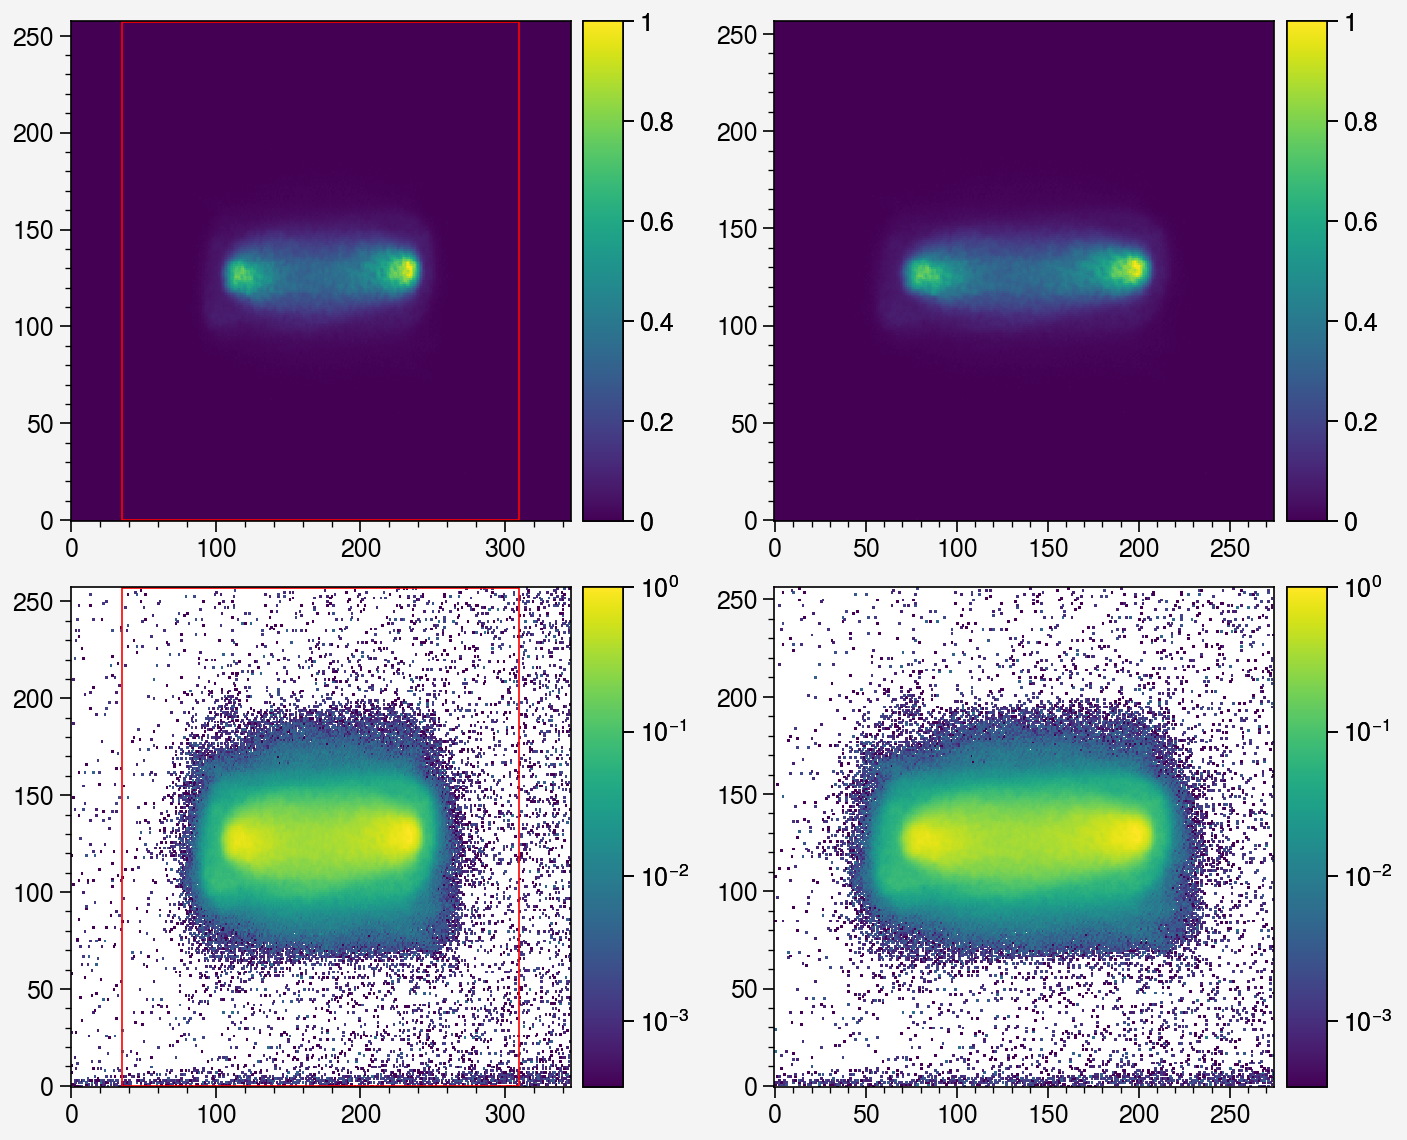

In [32]:
im = im_max.copy()
im1 = ip.crop(im, **image_crop_edges)

axes = plot_compare_images(im, im1, colorbar=True)
for ax in axes[:, 0]:
    ax.add_patch(patches.Rectangle((x1, y1), im1.shape[1], im1.shape[0], fill=False, ec='red'))
plt.savefig('_output/crop.png')
plt.show()

Make sure that nothing important will be cropped by looking at x/y projections of images across all frames with `signal > thresh`.

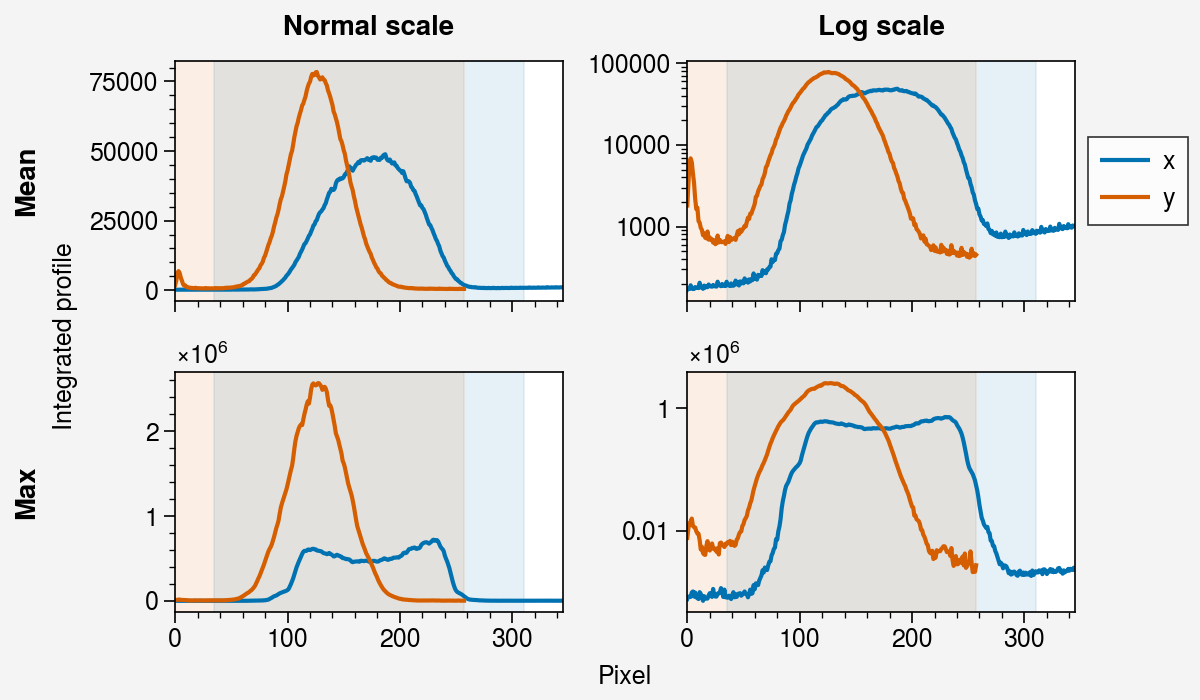

In [33]:
# Extract x and y profiles 
xprofs = data[valid, cam + '_ProfileX']
yprofs = data[valid, cam + '_ProfileY']

# Plot mean and max heights of all x/y profiles.
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(6, 3.5), sharey=1)
for j in range(2):
    for ax, func in zip(axes[:, j], [np.mean, np.max]):
        for profs, label in zip([xprofs, yprofs], ['x', 'y']):
            ax.plot(np.arange(profs.shape[1]), func(profs, axis=0), label=label)
axes[0, 1].legend(ncols=1, loc='r')
# Plot light blue{orange} in uncropped x{y} region.
colors = pplt.Cycle('colorblind').by_key()['color']
for _x1, _x2, _xmax, c in zip([x1, y1], [x2, y2], [xprofs.shape[1], yprofs.shape[1]], colors):
    if _x2 < 0:
        _x2 += _xmax
    for ax in axes:
        ax.axvspan(_x1, _x2, color=c, alpha=0.1)
axes[:, 1].format(yscale='log')
axes.format(leftlabels=['Mean', 'Max'], toplabels=['Normal scale', 'Log scale'],
            xlabel='Pixel', ylabel='Integrated profile')
plt.savefig('_output/crop2.png')
plt.show()

In [34]:
info['image_crop_edges'] = image_crop_edges
im = im1.copy()

### Threshold

Sometimes there is a constant pixel offset in the images.

  0%|          | 0/1154 [00:00<?, ?it/s]

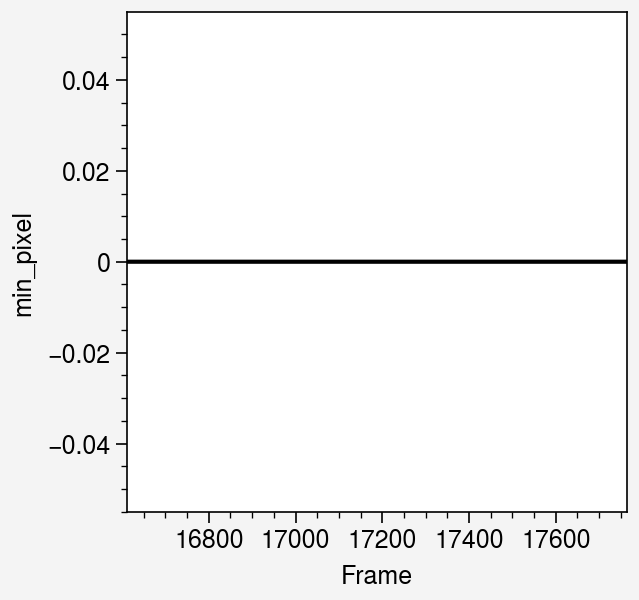

In [35]:
window = int(0.01 * len(data))
frames = np.arange(imin - window, imin + window, 1)
min_pixels = [np.min(ip.crop(get_image(i), **image_crop_edges)) for i in tqdm(frames)]

fig, ax = pplt.subplots()
ax.plot(frames, min_pixels, color='black')
ax.format(xlabel='Frame', ylabel='min_pixel')
plt.savefig('_output/offset.png')
plt.show()

In [36]:
image_offset = np.mean(min_pixels)
info['image_offset'] = image_offset
print('image_offset = ', image_offset)

im = im - image_offset

image_offset =  0.0


Select images that are obviously measuring noise — a window near `imin` — and use the maximum pixel from those images as the threshold. Tune `width_view` to view more frames; tune `width_select` to select the frames.

For selected images:
max pixel: 2900
min noise: 0
mean noise: 11.893979925716307
std noise: 81.8684795750428


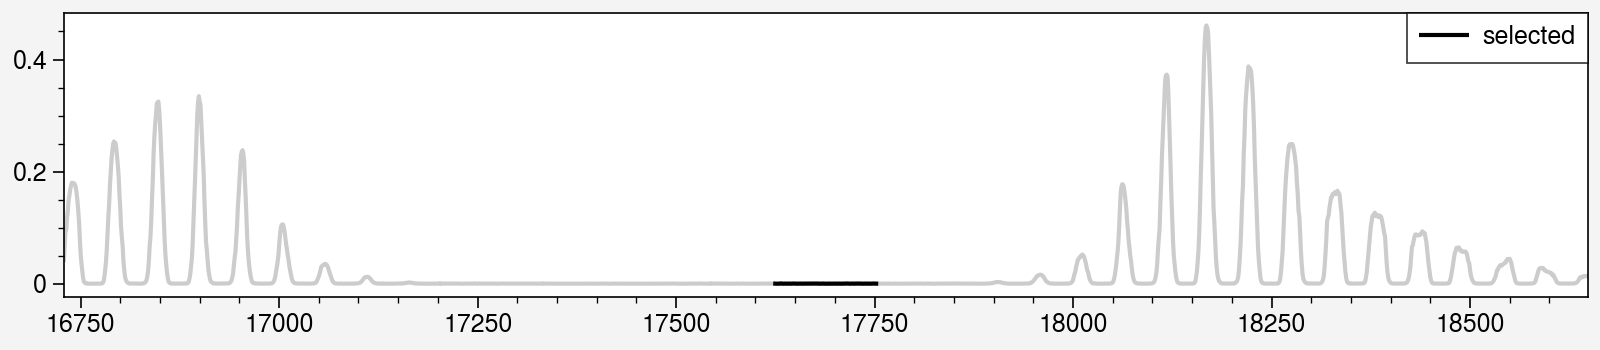

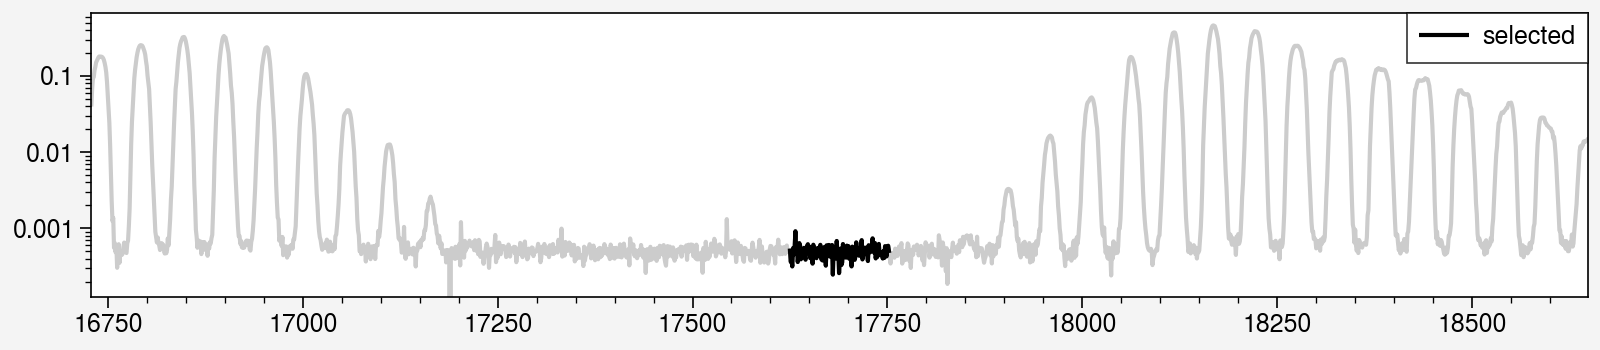

In [37]:
width_view = 30 * variables['y1']['steps']
width_calc = 2 * variables['y1']['steps']
icenter = imin  + 500
info['noise_icenter'] = icenter
idx_view = np.arange(icenter - width_view, icenter + width_view, 1)
idx_calc = np.arange(icenter - width_calc, icenter + width_calc, 1)
ims_noise = np.array([ip.crop(get_image(i), **image_crop_edges) for i in idx_calc])
print('For selected images:')
print(f'max pixel: {np.max(ims_noise)}')
print(f'min noise: {np.min(ims_noise)}')
print(f'mean noise: {np.mean(ims_noise)}')
print(f'std noise: {np.std(ims_noise)}')

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 1.75))
    ax.plot(idx_view, signal[idx_view], color='black', alpha=0.2)
    ax.plot(idx_calc, signal[idx_calc], color='black', label='selected')
    ax.legend(loc='upper right')
    ax.format(yscale=yscale)
    plt.savefig(f'_output/noise_region_{yscale}.png')
    plt.show()

View how the thresholding affects the images.

In [38]:
image_thresh = 0.5 * (np.max(ims_noise) - image_offset)
image_thresh_frac_peak = image_thresh / np.max(im)

print(f'image_thresh = {image_thresh}')
print(f'10^{np.log10(image_thresh_frac_peak):.2f} of max pixel in peak integral image')

image_thresh = 1450.0
10^-2.29 of max pixel in peak integral image


In [39]:
def update(i, log, discrete, handle_log, thresh):
    _im = get_image(i)
    _im = ip.crop(_im, **image_crop_edges)
    _im = _im - image_offset
    _im[_im <= thresh] = 0
    norm = 'log' if log else None
    fig, ax = pplt.subplots()
    mplt.plot_image(_im.T / np.max(_im), ax=ax, colorbar=True, norm=norm, 
                    discrete=discrete, handle_log=handle_log)
    plt.show()
    
interactive(
    update, i=(imax - 99, imax + 101), log=True, discrete=False,
    handle_log=['floor', 'mask'], 
    thresh=widgets.FloatSlider(min=0.0, max=4.0 * image_thresh, 
                               step=0.1 * image_thresh, value=image_thresh),
)

interactive(children=(IntSlider(value=28882, description='i', max=28982, min=28782), Checkbox(value=True, desc…

Save results for test image.

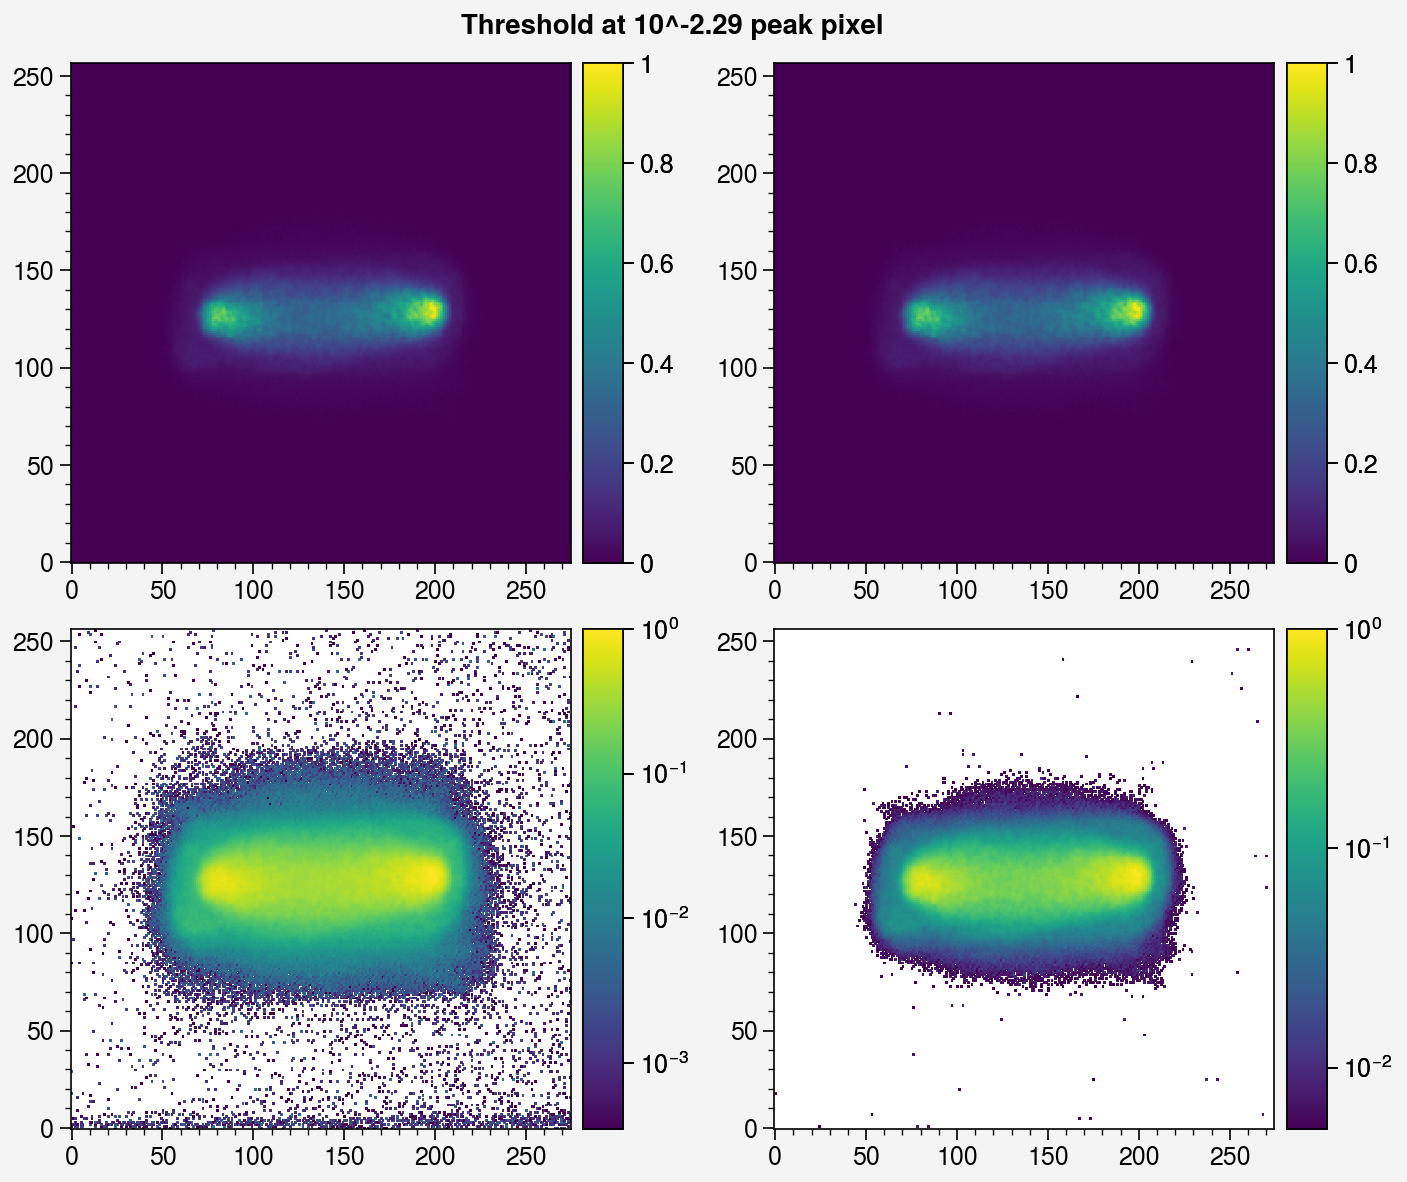

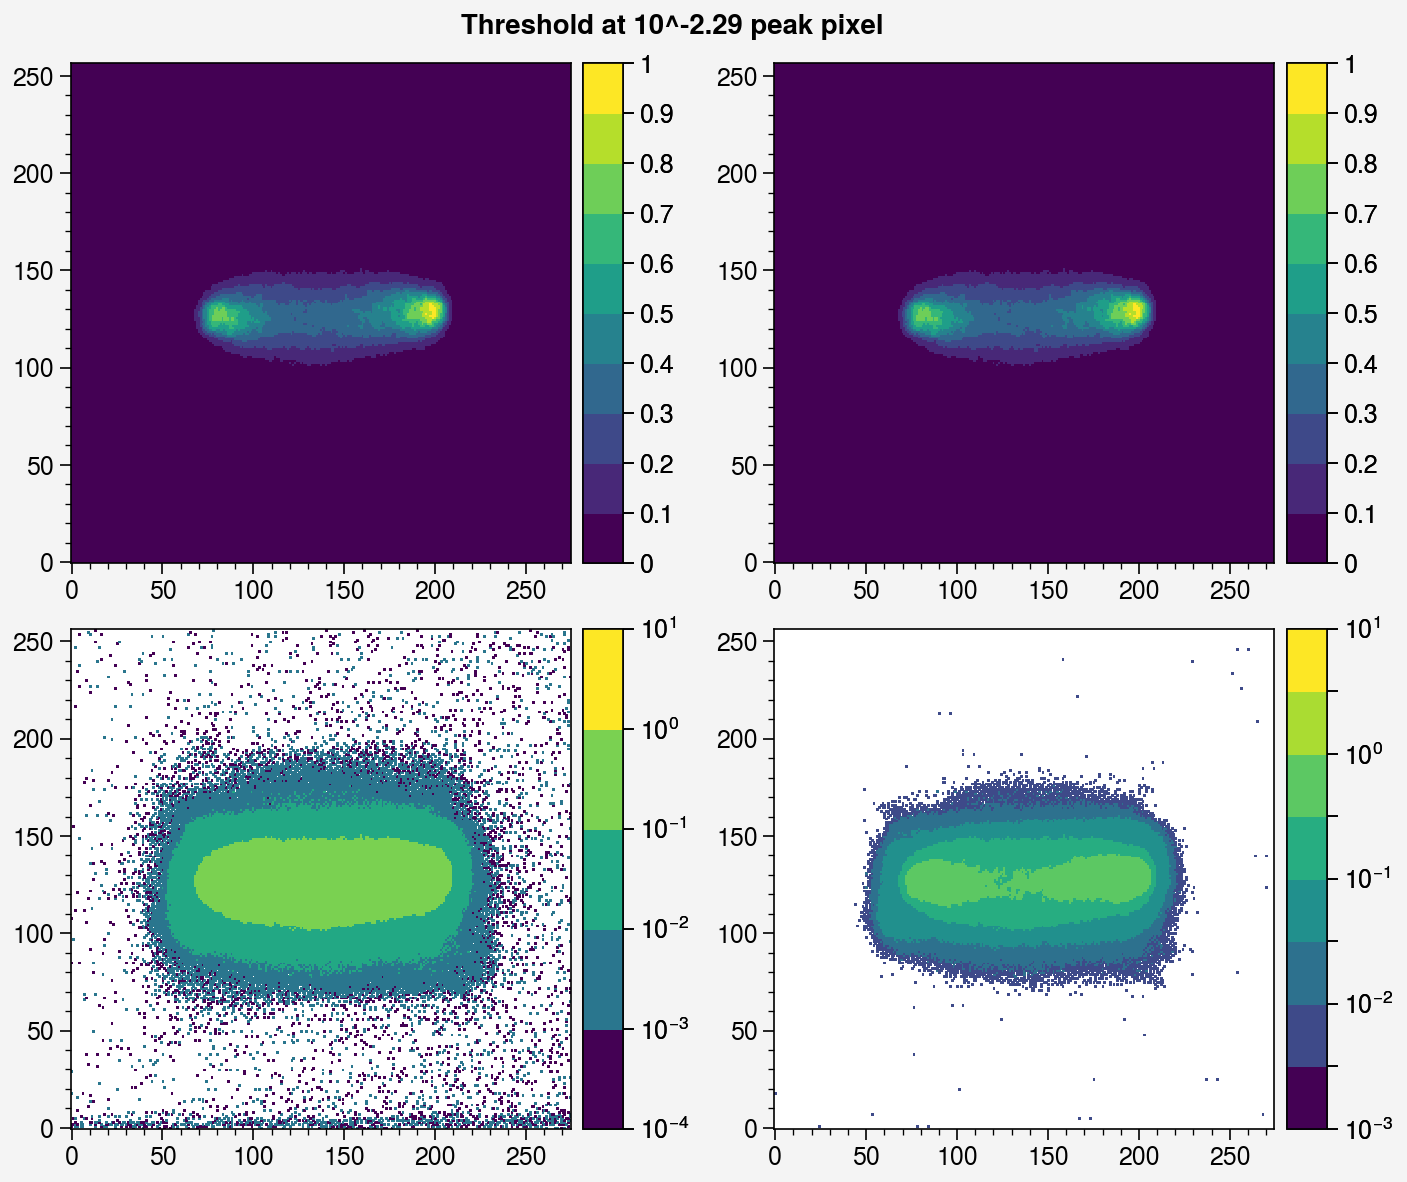

In [40]:
im1 = im.copy()
im1[im1 <= image_thresh] = 0
info['image_thresh'] = image_thresh

for discrete in [False, True]:
    axes = plot_compare_images(im / np.max(im), im1 / np.max(im1), colorbar=True, 
                               discrete=discrete, handle_log='mask')
    axes.format(suptitle=f'Threshold at 10^{np.log10(image_thresh_frac_peak):.2f} peak pixel')
    plt.savefig(f'_output/thresh_discrete{discrete}.png')
    plt.show()

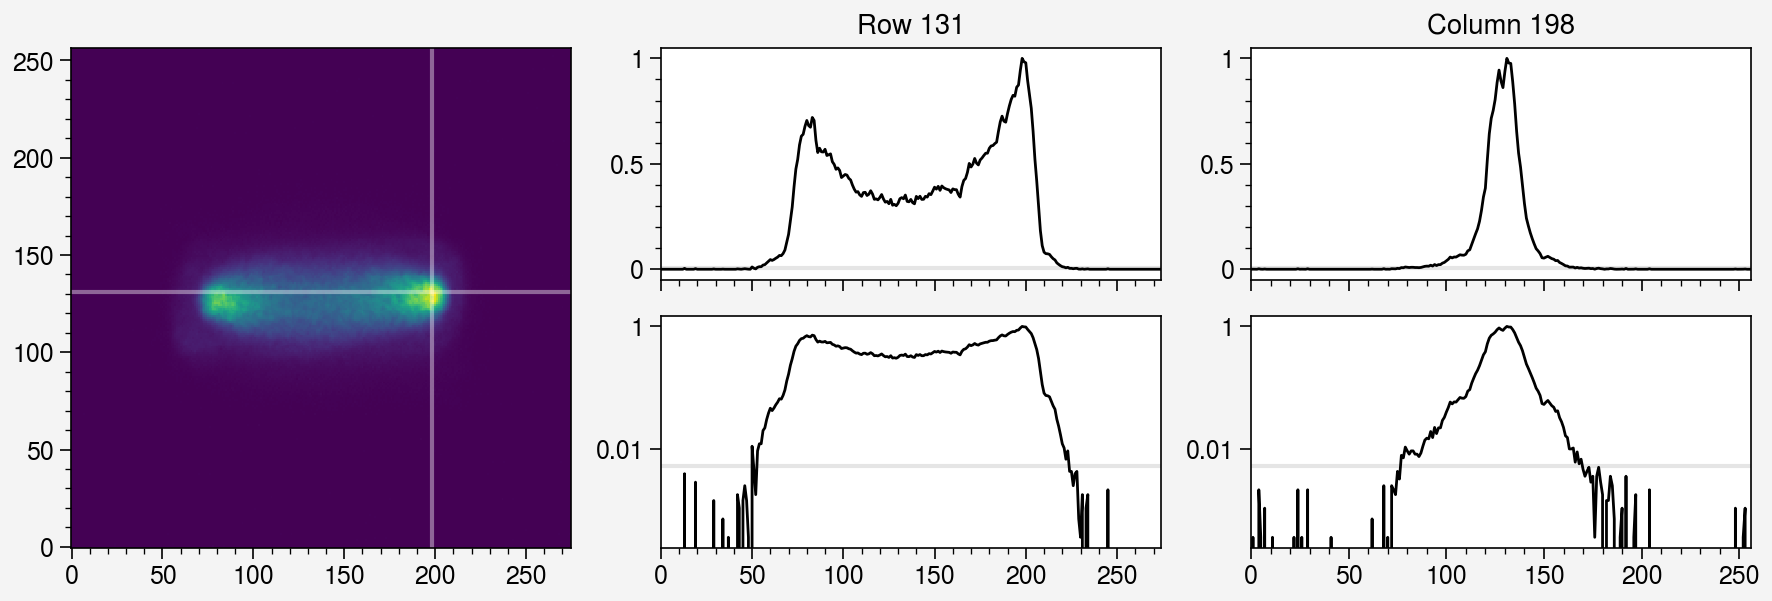

In [41]:
i, j = np.unravel_index(np.argmax(im), im.shape)
fig, axes = pplt.subplots([[1, 2, 3], [1, 4, 5]], sharey=False)
axes[0].pcolormesh(im)
kws = dict(color='white', alpha=0.4)
axes[0].axhline(i, **kws)
axes[0].axvline(j, **kws)
axes[1].set_title(f'Row {i}')
axes[2].set_title(f'Column {j}')
kws = dict(color='black', lw=1.0)
for ax in axes[:, 1]:
    ax.plot(np.arange(im.shape[1]), im[i, :] / np.max(im[i, :]), **kws)
    ax.axhline(image_thresh / np.max(im[i, :]), color='black', alpha=0.1)
for ax in axes[:, 2]:
    ax.plot(np.arange(im.shape[0]), im[:, j] / np.max(im[:, j]), **kws)
    ax.axhline(image_thresh / np.max(im[:, j]), color='black', alpha=0.1)
axes[1:, 1:].format(yscale='log')
plt.savefig('_output/thresh2.png')
plt.show()

In [42]:
im = im1.copy()

### Downscale 

In [43]:
def update(i, log, downscale, handle_log):
    _im = get_image(i)
    _im = ip.crop(_im, **image_crop_edges)
    _im = _im - image_offset
    _im[_im <= image_thresh] = 0
    _im = skimage.transform.downscale_local_mean(_im, (downscale, downscale))
    norm = 'log' if log else None
    fig, ax = pplt.subplots()
    mplt.plot_image(_im.T / np.max(_im), ax=ax, colorbar=True, norm=norm, handle_log=handle_log)
    plt.show()
    
interactive(
    update, i=(imax - 99, imax + 101), log=True, 
    downscale=widgets.IntSlider(min=1, max=10, value=3),
    handle_log=['mask', 'floor'],
)

interactive(children=(IntSlider(value=28882, description='i', max=28982, min=28782), Checkbox(value=True, desc…

Save results for test image.

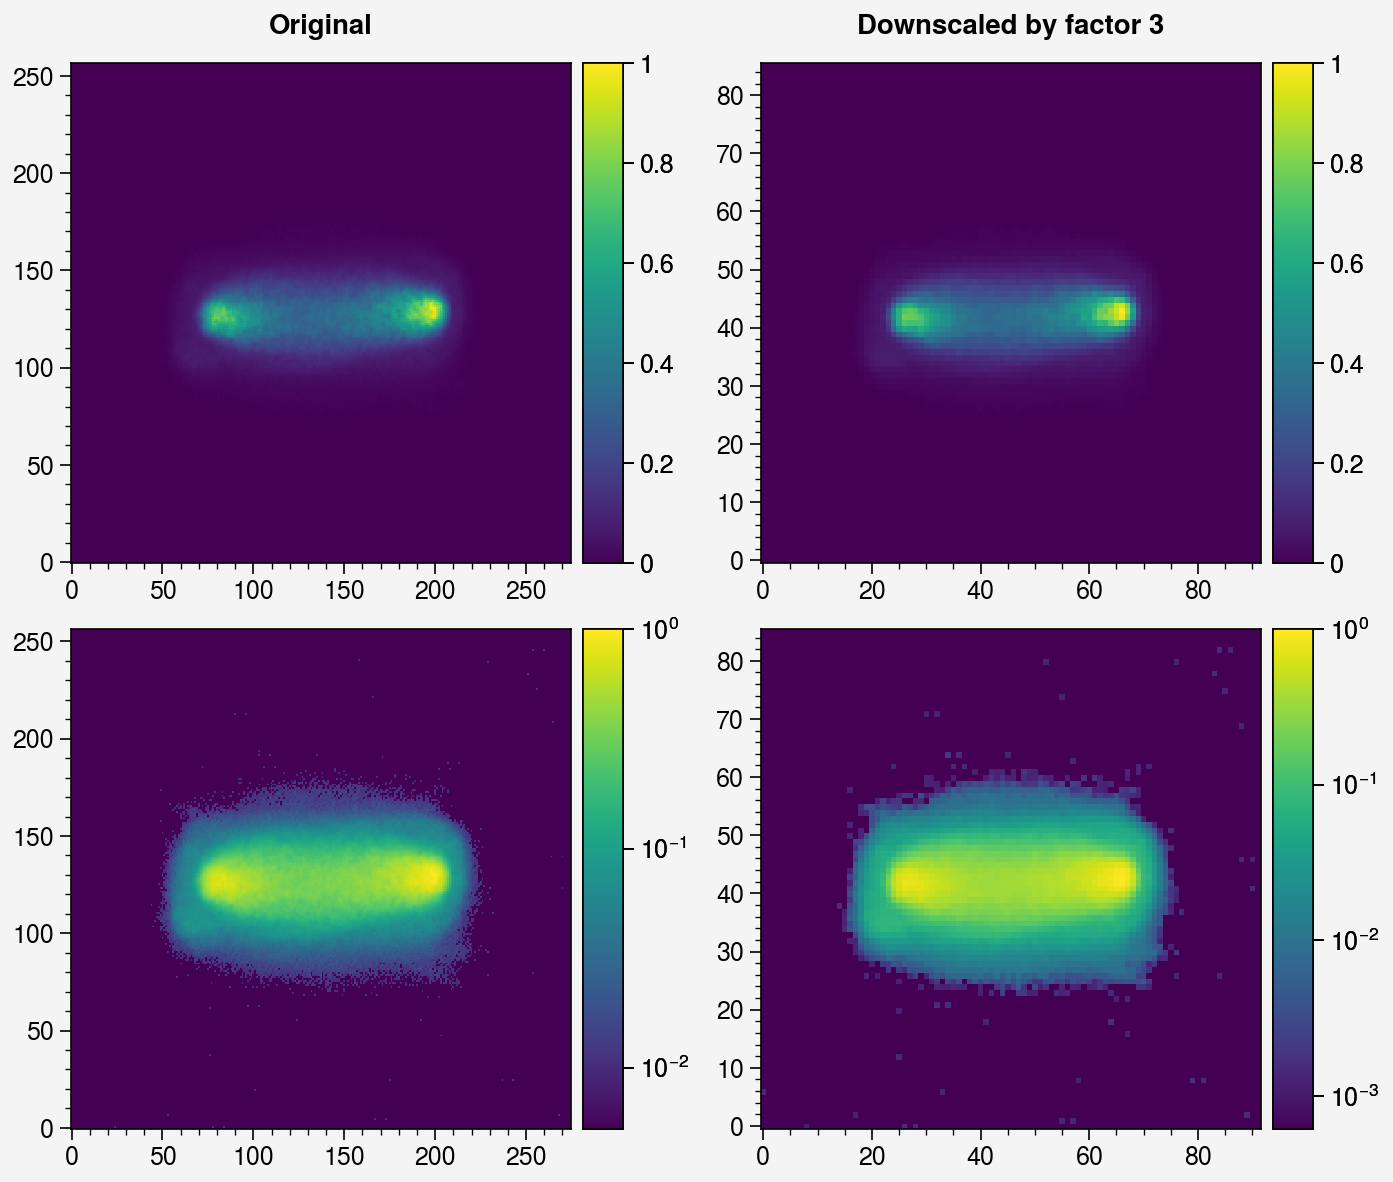

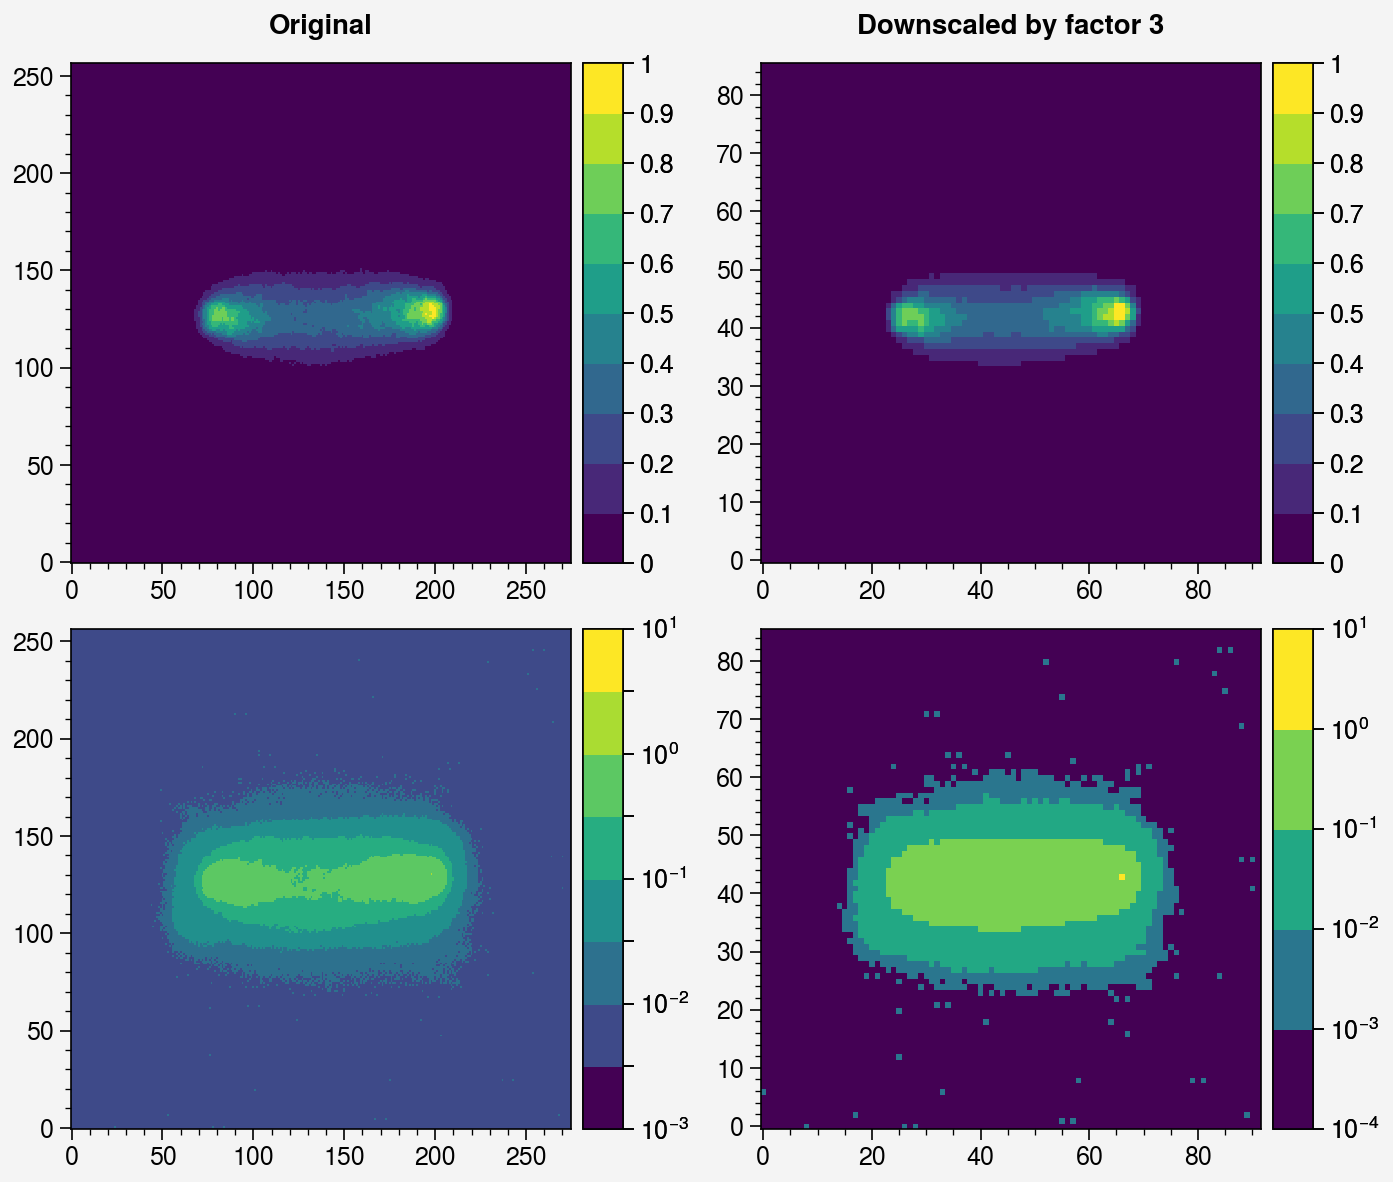

In [44]:
image_downscale = 3
info['image_downscale'] = image_downscale
    
im1 = skimage.transform.downscale_local_mean(im, (image_downscale, image_downscale))

for discrete in [False, True]:
    axes = plot_compare_images(im / np.max(im), im1 / np.max(im1), colorbar=True, discrete=discrete,
                               handle_log='floor')
    axes.format(toplabels=['Original', f'Downscaled by factor {image_downscale}'])
    plt.savefig(f'_output/downscale_discrete{discrete}.png')

Save new image shape and pixel/mm calibration.

In [45]:
info['image_shape'] = im1.shape
info['image_pix2mm_x'] = cam_settings.pix2mm * im.shape[0] / im1.shape[0]
info['image_pix2mm_y'] = cam_settings.pix2mm * im.shape[1] / im1.shape[1]
print('Original (cropped) image shape:', im.shape)
print('Downscaled image shape:', im1.shape)
print(f'Original pix2mm_x = pix2mm_y = {cam_settings.pix2mm}')
print('new pix2mm_y =', info['image_pix2mm_y'])
print('new pix2mm_x =', info['image_pix2mm_x'])

Original (cropped) image shape: (257, 275)
Downscaled image shape: (86, 92)
Original pix2mm_x = pix2mm_y = 0.19969696969696968
new pix2mm_y = 0.5969202898550724
new pix2mm_x = 0.596768851303735


## Write new h5 file

Make a function that does all of the above.

In [46]:
def process_image(im, crop_edges, offset, thresh, downscale):
    im = ip.crop(im, **crop_edges)
    im = im - offset
    im[im <= thresh] = 0
    downscale = max(1, downscale)
    im = skimage.transform.downscale_local_mean(im, (downscale, downscale))
    return im

Pass info dict to future notebooks. 

In [47]:
print('info:')
pprint(info)

# Save as pickled dictionary for easy loading.
utils.save_pickle('_output/info.pkl', info)

# Also save as file for viewing.
file = open('_output/info.txt', 'w')
for key, value in info.items():
    file.write(f'{key}: {value}\n')
file.close()

info:
{'M': array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.65],
       [0.  , 0.  , 1.  ]]),
 'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'cam': 'cam06',
 'cam_pix2mm_x': 0.19969696969696968,
 'cam_pix2mm_y': 0.19969696969696968,
 'cam_shape': (258, 346),
 'cam_zoom': 0.33,
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2021-12-03',
 'filename': 'merged2-211203151919-211203192701-scan-xxpy-image-ypdE',
 'image_crop_edges': {'x1': 35, 'x2': 310, 'y1': 0, 'y2': 257},
 'image_downscale': 3,
 'image_offset': 0.0,
 'image_pix2mm_x': 0.596768851303735,
 'image_pix2mm_y': 0.5969202898550724,
 'image_shape': (86, 92),
 'image_thresh': 1450.0,
 'ndim': 3,
 'noise_icenter': 17689,
 'signal_thresh': 0.00175,
 'variables': {'x1': {'center': 13.0,
                      'distance': 17.0,
                      'max': 50.0,
                      'min': -50.0,
                      'pvname': 'ITSF_Diag:Slit_VT04',
                      'steps': 32},
           

Create a new h5 file with three data sets: scalar (0d), waveform (1d), and image (2d). First, collect the appropriate dtypes.

In [48]:
im = im1.copy()
attrs = data.dtype.names
sc_dtype, sc_attrs = [], list(attrs)
print(sc_attrs)
wf_dtype, wf_attrs = [], []
im_dtype, im_attrs = [], []
print('Moving the following columns:')
for i in reversed(range(len(attrs))):
    attr = attrs[i]
    if '_Image' in attr:
        sc_attrs.pop(i)
        im_attrs.append(attr)
        im_dtype.append((attr, data.dtype[attr]))
        print(attr)
    elif 'Profile' in attr:
        sc_attrs.pop(i)
        wf_attrs.append(attr)
        wf_dtype.append((attr, data.dtype[attr]))
        print(attr)
    else:
        sc_dtype.append((attr, data.dtype[attr]))
        
sc_dtype = np.dtype(sc_dtype)
wf_dtype = np.dtype(wf_dtype)
im_dtype = np.dtype(im_dtype)

# Override the image dtype. 
im_dtype = np.dtype([(cam + '_Image', str(im.dtype), (im.size,))])

print('\nscalars:')
print(sc_dtype)
print('\nwaveforms:')
print(wf_dtype)
print('\nimage:')
print(im_dtype)

['timestamp', 'iteration', 'cam06_Image', 'cam06_ProfileY', 'cam06_ProfileX', 'cam06_Saturation', 'cam06_Integral', 'bcm04', 'y_PositionSync', 'xp_PositionSync', 'x_PositionSync']
Moving the following columns:
cam06_ProfileX
cam06_ProfileY
cam06_Image

scalars:
[('x_PositionSync', '<f8'), ('xp_PositionSync', '<f8'), ('y_PositionSync', '<f8'), ('bcm04', '<f8'), ('cam06_Integral', '<f8'), ('cam06_Saturation', '<f8'), ('iteration', '<i8'), ('timestamp', '<f8')]

waveforms:
[('cam06_ProfileX', '<f4', (346,)), ('cam06_ProfileY', '<f4', (258,))]

image:
[('cam06_Image', '<f8', (7912,))]


Skip invalid points.

In [49]:
n_valid = len(valid_bcm)
print(f'Number of valid points: {n_valid}')
for i in range(len(data)):
    if i not in valid_bcm:
        print(f'Will skip point {i} due to bcm current {np.abs(bcm_data[i]):.2f} < {bcm_limit:.2f}')

Number of valid points: 57759
Will skip point 12039 due to bcm current 0.00 < 20.00
Will skip point 23125 due to bcm current 15.98 < 20.00
Will skip point 28507 due to bcm current 0.02 < 20.00
Will skip point 36677 due to bcm current 0.00 < 20.00
Will skip point 37583 due to bcm current 5.88 < 20.00
Will skip point 39390 due to bcm current 0.01 < 20.00
Will skip point 42479 due to bcm current 19.61 < 20.00


In [50]:
writer = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'w')
data_sc = writer.create_dataset('scalardata', (n_valid,), dtype=sc_dtype)
if len(wf_dtype) > 0:
    data_wf = writer.create_dataset('wfdata', (n_valid,), dtype=wf_dtype)
data_im = writer.create_dataset('imagedata', (n_valid,), dtype=im_dtype)
for i, j in enumerate(tqdm(valid_bcm)):
    for attr in sc_attrs:
        data_sc[i, attr] = data[j, attr]
    if len(wf_dtype) > 0:
        for attr in wf_attrs:
            data_wf[i, attr] = data[j, attr]
    for attr in im_attrs:
        image = process_image(get_image(j), image_crop_edges, image_offset, image_thresh, image_downscale)
        data_im[i, attr] = image.ravel()
writer.close()

  0%|          | 0/57759 [00:00<?, ?it/s]

Save static html of this notebook.

In [51]:
! jupyter nbconvert scan-xxpy-image-ypdE_step0.ipynb --to html
! mv scan-xxpy-image-ypdE_step0.html ./_output
! ls _output

[NbConvertApp] Converting notebook scan-xxpy-image-ypdE_step0.ipynb to html
[NbConvertApp] Writing 4246588 bytes to scan-xxpy-image-ypdE_step0.html
 acts.png		       offset.png
 bcm_mask.png		       pauses.png
 bcm_unmasked_points.png       points_nn3d.html
 cam06_Saturation.png	       points_true.png
 crop2.png		       points_upright.png
 crop.png		      'points_upright + scaled.png'
 downscale_discreteFalse.png   radial_dist_log.png
 downscale_discreteTrue.png    radial_dist_None.png
'image_Max integral.png'       scan-xxpy-image-ypdE_step0.html
'image_Min integral.png'       signal_thresh_log.png
 info.pkl		       signal_thresh_None.png
 info.txt		       thresh2.png
 noise_region_log.png	       thresh_discreteFalse.png
 noise_region_None.png	       thresh_discreteTrue.png
